In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
from nltk.tokenize import TweetTokenizer
from gensim import corpora, models, matutils
import numpy as np
from sklearn import metrics
from operator import itemgetter
from collections import Counter
import json
import gzip
from pprint import pprint
import os
import re

In [3]:
def read_tweets_from_file(category, results_path):
    switcher = {
        "nw": "nw.txt",
        "food": "food.txt",
        "politics": "politics.txt",
        "wellness": "wellness.txt",
        "entertainment": "entertainment.txt",
        "election": "election.txt",
        "nasa":"nasa.txt",
        "addele" : "addele.txt",
        "sport" : "sport.txt"
        }
    file_name = switcher.get(category)
    with open(results_path + file_name, 'rb') as f:
        tweets = f.read().splitlines()
    f.close()
    return tweets

In [4]:
%matplotlib inline
import os
import wordcloud
import matplotlib.pyplot as plt

In [12]:
def Clustering_Tweets(category, path, exp, cluster_size, dup_removed=0):
    
    plt.close('all')
    fig, axs = plt.subplots(ncols=cluster_size, sharey=True, figsize=(10, 5))

    with open(path + category, 'rb') as f:
        tweets = f.read().splitlines()

    #if (int(exp)==2):
        #removing duplicate tweets
    #    tweets_all = read_tweets_from_file(category, path)
    #    tweets = set(tweets_all)
    #else:
    #    tweets = read_tweets_from_file(category, path)
    
    stoplist = set([line.replace("\n","") for line in open('/Users/ynh3/Data/stopword-list2.txt')])
    pun = [',', '-','.', ':', '(', ')', '--', ';', '...', 'today','follow','stats','can', 'say', 'says', 'will','may', 'must', 'us', 'via','a','the', 'rt', 'gg', 'gt', 'lt', 'la', 'de', 'te', 'lol', 'follow', 'followers', 'unfollow', 'unfollowers', 'unfollower', 'follower']

    with open('/Users/ynh3/Data/common_list.txt','rt') as myfile:
        common_word = myfile.read().splitlines()
    #len(common_word)

    #Tokenize
    tknzr = TweetTokenizer()   
    tweet_count = 0
    tweet_tokens=[]
    tweet_list=[]
    i = 0

    for line in tweets:

        new_l = tknzr.tokenize(line)
        lower_l = [e.lower() for e in new_l]
        new_ll = [e for e in lower_l if e not in stoplist and e not in common_word and e not in pun and len(e) > 2 and e.isalpha() and 'http' not in e and '@' not in e]
        
        #removing duplicate after tokenizing
        if (int(exp)==3):
            if (new_ll not in tweet_tokens):
                if len(new_ll) > 0:
                    tweet_tokens.append(new_ll)
                    tweet_count += 1
                    tweet_list.append(line)

        else:
            if len(new_ll) > 0:
                tweet_tokens.append(new_ll)
                tweet_count += 1
                tweet_list.append(line)
            
        i += 1


    print "Done with tokenizations. tweets count: " , tweet_count
    
    dictionary = corpora.Dictionary(tweet_tokens)
    print(dictionary)

    corpus = [dictionary.doc2bow(t) for t in tweet_tokens]

    n_cluster = cluster_size
    
    # LSI computing
    if (int(exp)==1):
        lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=n_cluster) # initialize an LSI transformation
        corpus_lsi = lsi[corpus]
    else:
        tfidf = models.TfidfModel(corpus)
        corpus_tfidf = tfidf[corpus]


        lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=n_cluster) # initialize an LSI transformation
        corpus_lsi = lsi[corpus_tfidf]

    '''for t in range(lsi.num_topics):
        plt.figure()
        s = lsi.show_topic(t,  topn=5)
        print "in the loop -----------------"
        print s
        plt.imshow(wordcloud.WordCloud().fit_words(s))
        plt.axis("off")
        plt.title("Topic #" + str(t))
        plt.show()'''
    
        
    j = 0
    lsi_topic_labels=[]
    for i,doc in enumerate(corpus_lsi):
        a = np.array(doc)
        absA= abs(a)
        if (len(a)==0):
            cluster_id=0
            prob_value=0.0
            j=j+1
        else:
            try:
                topicmax = absA.argmax(axis=0)
            except ValueError:
                print "ValueError at"
                print i
            cluster_id = a[topicmax.item(1)][0]
            prob_value = abs(a[topicmax.item(1)][1])

        triple = i, cluster_id, prob_value
        lsi_topic_labels.append(triple)
        
        '''l = lsi.print_topic(cluster_id,topn=10)
        
        ##trying new topic words instead of following three lines
        #prob_list = [(abs(float(a[:5])),a[6:])  for a in (l.split('+ '))]
        #sorted(prob_list)
        #t_words = [w[1] for w in prob_list]
        
        #t_words'''

        i=i+1

   
    ##For silhouette score
    labels = [b for a,b,c in lsi_topic_labels]
    np_labels = np.asarray(labels)

    # convert corpus to array
    corpusAsMatrix = matutils.corpus2dense(corpus_lsi, num_terms=n_cluster).transpose()

    score = metrics.silhouette_score(corpusAsMatrix, np_labels, metric='cosine')

    print 'silhouette score is: {}'.format(score)
    
    ###MAKING READY FOR sorting, categorizing and writing into file
    temp = sorted(lsi_topic_labels,key=itemgetter(1,2), reverse=True)
    cluster_topic_list = [e for e in temp if float(e[2]) > 0.2]
    #leftovers_list = [tweet_list[e[0]] for e in temp if float(e[2]) <= 0.2]
    #Counter(a,b,c for a,b,c in lsi_topic_labels)

    cluster_list = sorted(cluster_topic_list,key=lambda x: x[1])
    counter = Counter(b for a,b,c in cluster_list)
    counter_sort = counter.most_common(n_cluster)
    cid_sort = [e[0] for e in counter_sort]

    #print 'length of lsi_topic_labels is {}'.format(len(lsi_topic_labels))
    #print 'length of cluster_list is {}'.format(len(cluster_list))
    #print 'length of counter_sort is {}'.format(len(counter_sort))
    print 'n_cluster is {}'.format(n_cluster)
    #print 'cid_sort is {}'.format(len(cid_sort))

    #t = lsi.show_topics()
    #with open(path + category + '_exp1_topics_v1_' + str(cluster_size) + '.txt', 'wt') as myfile:
    #    myfile.write('\n\n'.join(t))
    
    #path = path  + "Experiments_set2/"
    
    myfile = open(path + category + '_exp' + str(exp) + '_topics_v' + str(dup_removed)+ '_c' + str(cluster_size) + '.txt', 'wt')
    
        
    output_file = open(path + category + '_exp' + str(exp) + '_clusters_v' + str(dup_removed)+ '_c' + str(cluster_size) + '.txt', 'w')

    data_list=[]
    data = {}
    count=0
    i=0

    for i in range(0, len(cid_sort)):
        sublist = [e for e in cluster_topic_list if e[1] == cid_sort[i]]
        t_index = int(cid_sort[i])
        #count = int(counter_sort[i][1])
        #start = sum([e[1] for e in counter_sort[:i]])
        #sublist = cluster_topic_list[start:count]
        #pdb.set_trace()
        #if i < 2: print start, count, len(sublist)

        topic = lsi.print_topic(t_index,topn=10)
        
        ##trying new topic words instead of following line
        #prob_list = [((float(a[:5])),a[6:])  for a in (topic.split('+'))]

        ##
        
        ##topic word preparation
        new_list = [a  for a in (topic.split('+'))]
        new_list = "".join(new_list)

        prob_list = re.findall(r"[-+]?\d*\.\d+|\d+", new_list)

        topic_word = re.findall(r"[^\W\d_]+", new_list)

        topic_tuple = zip(prob_list,topic_word)
        #print topic_tuple

        neg_prob = [float(p) for p in prob_list if float(p) < 0]
        pos_prob = [float(p) for p in prob_list if float(p) > 0]
        #print sum(neg_prob), sum(pos_prob)

        if len(pos_prob) > len(neg_prob) or abs(sum(pos_prob)) > abs(sum(neg_prob)):
            t_words = [w for p,w in topic_tuple if float(p) > 0]
        else:
            t_words = [w for p,w in topic_tuple if float(p) < 0]

        all_t_words = [w for p,w in topic_tuple]
        all_t = ' '.join(all_t_words)

        topic = ' '.join(t_words)
    
        
        string = ' '.join(topic)
        if string == "":
            print i
            print cid_sort[i], t_index
            print topic
            #print sublist

            break
        '''
        ##using WordCloud to show topic words
        curr_topic = t_index
    
        sorted_topic_tuple = sorted(topic_tuple, key=lambda x:x[0],reverse=True)
    
        freqs = []
        freqs = dict((word, float(score)) for (score, word) in sorted_topic_tuple)

  
        wc = wordcloud.WordCloud()
        wc.width=120 
        wc.height=120

        elements = wc.fit_words(freqs)

        axs[curr_topic].set_title("Topic #" + str(curr_topic))
        axs[curr_topic].imshow(elements)
        plt.axis("off")'''
        ##End of using WordCloud

        
        if (int(dup_removed) == 0):
            l = [(float(ss[2]),tweet_list[ss[0]]) for ss in sublist if float(ss[2]) > 0.48]
        
        else:
            ##printing just unique and not duplicated tweets
            l_all = [(float(ss[2]),tweet_list[ss[0]]) for ss in sublist if float(ss[2]) > 0.48]
            temp = set(l_all)
            #temp = sorted(lsi_topic_labels,key=itemgetter(1,2), reverse=True)
            l = sorted(temp, key=lambda x:x[0],reverse=True)

            
        count += len(l)
        myfile.write('Topic # %d' %t_index + ': %s' %topic +'\n')
        #myfile.write('Topic # %d: %s' %t_index %topic +'\n')
        
        output_file.write("\n\n")
        output_file.write('Cluster # %d' %t_index + '-----------------------\n')
        output_file.write('Total items # %d' %len(l) + '-----------------------\n\n')
        output_file.write('Topic: %s' %topic +'\n')
        #output_file.write("\n".join(l))
        
        #writing the probability of each tweet for the current topic
        #output_file.write("".join("%s, %s\n" % tup for tup in l))
        output_file.write("".join("%s\n" % tup[1] for tup in l))

        print('Cluster # %d' %t_index + '-----------------------\n')
        print('Total items # %d' %len(l) + '-----------------------\n\n')
        print('Topic: %s' %topic+'\n')
        #print "".join("%s, %s\n" % tup for tup in l)
        print "".join("%s\n" % tup[1] for tup in l)
        #print("\n".join(l))

     
    print("Total number of tweets is {}".format(count))
    
    output_file.write('Total tweets being clustered is # %d' %count)
    output_file.close()

    #plt.show() 

Done with tokenizations. tweets count:  259
Dictionary(294 unique tokens: [u'freaking', u'opinions', u'executed', u'shot', u'forget']...)
silhouette score is: 0.223877772689
n_cluster is 10
Cluster # 0-----------------------

Total items # 59-----------------------


Topic: officer charged man shooting murder carolina south unarmed police shows

rt @yahoonews: white south carolina police officer to be charged with murder in fatal shooting of black man
south carolina officer is charged with murder after shooting an unarmed black man and its on tape! , via @nytimes http://t.co/ecqddvfwkj
rt @cnni: a south carolina officer is charged with murder after allegedly shooting an unarmed man: http://t.co/op0rbc0rso http://t.co/757fv
rt @nprnews: south carolina police officer charged with murder after shooting man in back http://t.co/7aol05ywgq
rt @micksarfo9: "@cnnbrk: police officer charged with murder after video shows him shooting unarmed man. http://t.co/j7furdys7d http://t.co
rt @gidi_traff

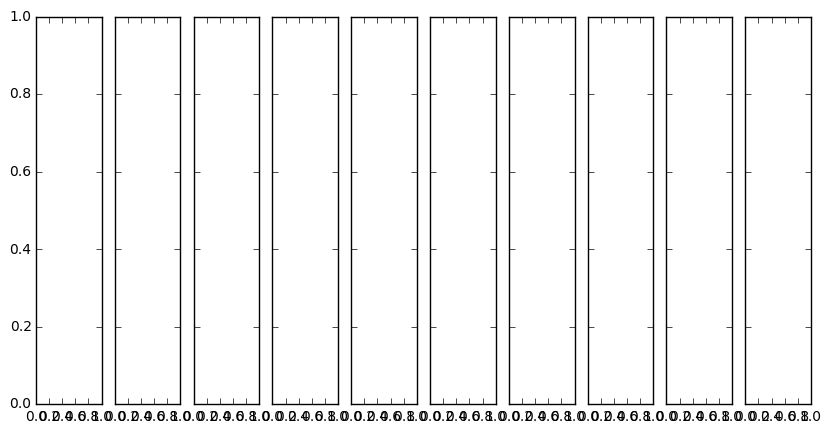

In [14]:
Clustering_Tweets("nw_exp1_cluster1.txt","/Users/ynh3/Documents/ExS/results/categorized_tweets_enhanced_2ndweek/Experiments_set2/",1,10,1)

In [ ]:
#######################